<a href="https://colab.research.google.com/github/MitjaGo/BAR/blob/main/ID3TAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
📸 Upload a default JPG/PNG thumbnail for all MP3s:


Saving count-music.jpg to count-music.jpg


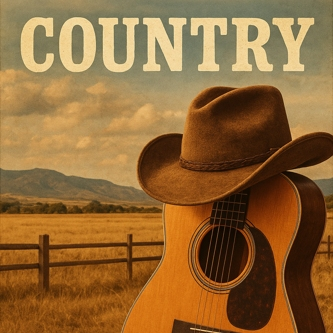


⬆️ Upload up to 50 MP3 files:


Saving Alan Jackson - Chattahoochee.mp3 to Alan Jackson - Chattahoochee.mp3
Saving Alan Jackson - Country Boy .mp3 to Alan Jackson - Country Boy .mp3
Saving Alan Jackson - Livin On Love.mp3 to Alan Jackson - Livin On Love.mp3
Saving Alan Jackson - Remember When.mp3 to Alan Jackson - Remember When.mp3
Saving Alan Jackson Jimmy Buffett - It s Five O Clock Somewhere.mp3 to Alan Jackson Jimmy Buffett - It s Five O Clock Somewhere.mp3
Saving Alan Jackson Small Town Southern Man.mp3 to Alan Jackson Small Town Southern Man.mp3
Saving Alan Jackson The Older I Get.mp3 to Alan Jackson The Older I Get.mp3
✅ Uploaded 7 MP3 files.
🖼️ Default thumbnail embedded into all MP3 files.


Label(value='📝 Edit MP3 Tags and optionally upload new thumbnails:')

Button(button_style='success', description='💾 Save All Tags', style=ButtonStyle())

Button(button_style='info', description='⬇️ Download All MP3s as ZIP', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ===========================================
# 🧩 INSTALL DEPENDENCIES
# ===========================================
!pip install eyed3 ipywidgets pillow

import eyed3
from google.colab import files
from IPython.display import display, Image
import ipywidgets as widgets
import zipfile
from datetime import datetime
import re
from PIL import Image as PILImage
import io

# ===========================================
# 📸 STEP 1: Upload default thumbnail
# ===========================================
print("📸 Upload a default JPG/PNG thumbnail for all MP3s:")
image_upload = files.upload()
img_name, default_img_data = next(iter(image_upload.items()))
display(Image(data=default_img_data, width=150))

# Resize image for compatibility
def resize_jpeg(img_data, max_size=500):
    img = PILImage.open(io.BytesIO(img_data))
    img.thumbnail((max_size, max_size))
    out = io.BytesIO()
    img.convert("RGB").save(out, format='JPEG', quality=85)
    return out.getvalue()

default_img_data = resize_jpeg(default_img_data)

# ===========================================
# 🎵 STEP 2: Upload MP3 files
# ===========================================
print("\n⬆️ Upload up to 50 MP3 files:")
upload = files.upload()
mp3_files = list(upload.keys())[:50]
print(f"✅ Uploaded {len(mp3_files)} MP3 files.")

# ===========================================
# 🖼️ Helper: Embed thumbnail
# ===========================================
def embed_thumbnail_eyed3(mp3_file, image_data):
    audiofile = eyed3.load(mp3_file)
    if audiofile.tag is None:
        audiofile.initTag()
    audiofile.tag.images.set(3, image_data, "image/jpeg", u"Cover")
    audiofile.tag.save(version=eyed3.id3.ID3_V2_3)

# Embed default thumbnail into all files
for f in mp3_files:
    embed_thumbnail_eyed3(f, default_img_data)
print("🖼️ Default thumbnail embedded into all MP3 files.")

# ===========================================
# 💿 STEP 3: Bulk Album Edit
# ===========================================
bulk_album_widget = widgets.Text(
    value='',
    description='Set Album for All:',
    layout=widgets.Layout(width='300px')
)
bulk_album_btn = widgets.Button(description='Apply to All', button_style='warning')
display(widgets.HBox([bulk_album_widget, bulk_album_btn]))

# ===========================================
# 🧠 STEP 4: Parse filename to extract Artist & Title
# ===========================================
def parse_filename(filename):
    """
    Example: '01 - Mina - Oggi Sono Io.mp3'
    → ('Mina', 'Oggi Sono Io')
    """
    name = re.sub(r'\.\w+$', '', filename)  # remove extension
    parts = re.split(r'\s*-\s*', name)
    parts = [p.strip() for p in parts if p.strip()]

    artist = ""
    title = ""

    if len(parts) >= 3:
        # e.g. ['01', 'Mina', 'Oggi Sono Io']
        artist = parts[1]
        title = " - ".join(parts[2:])
    elif len(parts) == 2:
        # e.g. ['Mina', 'Oggi Sono Io']
        artist, title = parts
    else:
        title = parts[0] if parts else filename

    return artist, title

# ===========================================
# 📝 STEP 5: Create editable widgets per file
# ===========================================
file_widgets = []

for f in mp3_files:
    audiofile = eyed3.load(f)
    if audiofile.tag is None:
        audiofile.initTag()

    # Try to parse filename if tags missing or empty
    parsed_artist, parsed_title = parse_filename(f)

    title = audiofile.tag.title or parsed_title or ""
    artist = audiofile.tag.artist or parsed_artist or ""
    album = audiofile.tag.album or ""

    title_widget = widgets.Text(value=title, description='Title:', layout=widgets.Layout(width='250px'))
    artist_widget = widgets.Text(value=artist, description='Artist:', layout=widgets.Layout(width='250px'))
    album_widget = widgets.Text(value=album, description='Album:', layout=widgets.Layout(width='250px'))
    img_widget = widgets.Image(value=default_img_data, format='jpeg', width=80, height=80)

    new_img_data = {'data': None}

    # Upload per-file thumbnail
    def make_upload_callback(img_w, store):
        def on_upload(change):
            uploaded = files.upload()
            if uploaded:
                _, data = next(iter(uploaded.items()))
                data_resized = resize_jpeg(data)
                img_w.value = data_resized
                store['data'] = data_resized
        return on_upload

    upload_btn = widgets.Button(description="📤 Change Thumbnail", layout=widgets.Layout(width='150px'))
    upload_btn.on_click(make_upload_callback(img_widget, new_img_data))

    hbox = widgets.HBox([
        img_widget,
        widgets.Label(f, layout=widgets.Layout(width='200px')),
        title_widget,
        artist_widget,
        album_widget,
        upload_btn
    ])

    file_widgets.append((f, title_widget, artist_widget, album_widget, img_widget, new_img_data, hbox))

display(widgets.Label("📝 Edit MP3 Tags and optionally upload new thumbnails:"))
for w in file_widgets:
    display(w[-1])

# ===========================================
# 💿 Bulk Album Button Function
# ===========================================
def on_bulk_album_clicked(b):
    album_name = bulk_album_widget.value.strip()
    for _, _, _, album_w, _, _, _ in file_widgets:
        album_w.value = album_name

bulk_album_btn.on_click(on_bulk_album_clicked)

# ===========================================
# 💾 STEP 6: Save & Download
# ===========================================
save_btn = widgets.Button(description="💾 Save All Tags", button_style='success')
zip_btn  = widgets.Button(description="⬇️ Download All MP3s as ZIP", button_style='info')
output   = widgets.Output()
display(save_btn, zip_btn, output)

def clean_filename(filename):
    # remove trailing "(1)" or similar duplicates
    return re.sub(r"\s*\(\d+\)(?=\.\w+$)", "", filename)

# Save all button
def on_save_clicked(b):
    for f, title_w, artist_w, album_w, img_w, new_img, _ in file_widgets:
        audiofile = eyed3.load(f)
        if audiofile.tag is None:
            audiofile.initTag()

        audiofile.tag.title = title_w.value.strip()
        audiofile.tag.artist = artist_w.value.strip()
        audiofile.tag.album = album_w.value.strip()

        image_data = new_img['data'] if new_img['data'] else default_img_data
        audiofile.tag.images.set(3, image_data, "image/jpeg", u"Cover")

        audiofile.tag.save(version=eyed3.id3.ID3_V2_3)

    with output:
        output.clear_output()
        print("✅ All MP3 tags and thumbnails updated successfully!")

# ZIP button
def on_zip_clicked(b):
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_name = f"edited_mp3s_{now}.zip"
    with zipfile.ZipFile(zip_name, "w") as z:
        for f, *_ in file_widgets:
            new_name = clean_filename(f)
            z.write(f, arcname=new_name)
    files.download(zip_name)

save_btn.on_click(on_save_clicked)
zip_btn.on_click(on_zip_clicked)


In [3]:
# Colab-ready MP3 bulk tag editor (enhanced)
# Run this entire cell in Google Colab.

!pip install -q eyed3 ipywidgets pillow

import os
import io
import re
import zipfile
from datetime import datetime
from collections import defaultdict
from random import choice

import eyed3
from google.colab import files
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
from PIL import Image as PILImage

# ---------------------------
# Helpers
# ---------------------------
WORKDIR = "/content/mp3_bulk_editor"
os.makedirs(WORKDIR, exist_ok=True)

def resize_jpeg(img_data, max_size=500):
    img = PILImage.open(io.BytesIO(img_data))
    img.thumbnail((max_size, max_size))
    out = io.BytesIO()
    img.convert("RGB").save(out, format='JPEG', quality=85)
    return out.getvalue()

def clean_filename(filename):
    return re.sub(r"\s*\(\d+\)(?=\.\w+$)", "", filename)

def parse_filename(filename):
    """Simple parse: '01 - Artist - Title.mp3' or 'Artist - Title.mp3'"""
    name = re.sub(r'\.\w+$', '', os.path.basename(filename))
    parts = re.split(r'\s*-\s*', name)
    parts = [p.strip() for p in parts if p.strip()]

    artist = ""
    title = ""

    if len(parts) >= 3:
        artist = parts[1]
        title = " - ".join(parts[2:])
    elif len(parts) == 2:
        artist, title = parts
    else:
        title = parts[0] if parts else os.path.basename(filename)

    return artist, title

def embed_image_to_tag(audiofile, image_bytes):
    if audiofile.tag is None:
        audiofile.initTag()
    # Remove existing images first to avoid duplicates if caller intends replacement
    try:
        audiofile.tag.images.remove("image/jpeg", None, None)
    except Exception:
        # remove may fail if no images - ignore
        pass
    audiofile.tag.images.set(3, image_bytes, "image/jpeg", u"Cover")
    audiofile.tag.save(version=eyed3.id3.ID3_V2_3)

# ---------------------------
# UI Widgets
# ---------------------------
out_main = widgets.Output()

upload_label = widgets.HTML("<b>Step 1 — Upload MP3 files or a ZIP containing folders of MP3s:</b>")
upload_btn = widgets.Button(description="Upload MP3s / ZIP", button_style='primary')

# Options
opt_auto_track = widgets.Checkbox(value=False, description="Auto track numbering (01,02,...)", indent=False)
opt_folder_cover = widgets.Checkbox(value=True, description="Use folder-specific cover images if available", indent=False)
opt_random_cover = widgets.Checkbox(value=False, description="Random cover per song (from folder images)", indent=False)

# Bulk cover replace
bulk_cover_btn = widgets.Button(description="Upload NEW bulk thumbnail (REPLACE all)", button_style='danger')
erase_before_bulk = widgets.Checkbox(value=True, description="Erase old images before bulk replace", indent=False)

# Bulk album
bulk_album_widget = widgets.Text(value='', description='Set Album for All:', layout=widgets.Layout(width='320px'))
bulk_album_btn = widgets.Button(description='Apply to All', button_style='warning')

# Save / Download
save_btn = widgets.Button(description="💾 Save All Tags", button_style='success')
zip_btn  = widgets.Button(description="⬇️ Download All MP3s as ZIP", button_style='info')

# Area for per-file editable widgets
files_box = widgets.VBox([])

display(upload_label, upload_btn,
        widgets.HBox([opt_auto_track, opt_folder_cover, opt_random_cover]),
        widgets.HTML("<b>Optional:</b>"),
        widgets.HBox([bulk_cover_btn, erase_before_bulk]),
        widgets.HBox([bulk_album_widget, bulk_album_btn]),
        widgets.HTML("<hr>"),
        files_box,
        widgets.HBox([save_btn, zip_btn]),
        out_main)

# ---------------------------
# State
# ---------------------------
state = {
    "uploaded_paths": [],          # list of absolute paths to mp3 files
    "file_widgets": [],            # list of tuples per file
    "default_img": None,           # bytes
    "folder_images": defaultdict(list),  # folder -> list of image bytes (and filenames)
}

# ---------------------------
# File handling: save uploaded content to WORKDIR
# ---------------------------
def save_uploaded_files(uploaded):
    saved_paths = []
    for fname, fbytes in uploaded.items():
        # Determine extension
        lower = fname.lower()
        path = os.path.join(WORKDIR, fname)
        with open(path, "wb") as fh:
            fh.write(fbytes)
        saved_paths.append(path)
    return saved_paths

def extract_zip_to_workdir(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(WORKDIR)

def scan_for_mp3s_and_images():
    mp3_list = []
    folder_images = defaultdict(list)
    for root, _, files_in in os.walk(WORKDIR):
        for nm in files_in:
            lower = nm.lower()
            full = os.path.join(root, nm)
            if lower.endswith(".mp3"):
                mp3_list.append(full)
            elif lower.endswith((".jpg", ".jpeg", ".png")):
                # read and store bytes (resized later when used)
                try:
                    with open(full, "rb") as f:
                        b = f.read()
                        folder_images[root].append((nm, b))
                except Exception:
                    pass
    return sorted(mp3_list), folder_images

# ---------------------------
# Build per-file widgets
# ---------------------------
def build_file_widgets():
    # clear existing
    for w in state["file_widgets"]:
        pass
    state["file_widgets"].clear()
    files_box.children = []

    mp3s, folder_images = scan_for_mp3s_and_images()
    state["folder_images"] = folder_images

    # If no mp3s found, show message
    if not mp3s:
        files_box.children = [widgets.HTML("<i>No MP3 files found yet. Upload files or a ZIP with MP3s.</i>")]
        return

    ui_rows = []
    for idx, mp3_path in enumerate(mp3s, start=1):
        audiofile = eyed3.load(mp3_path)
        if audiofile is None:
            # could not read file - skip
            title_val = ""
            artist_val = ""
            album_val = ""
        else:
            if audiofile.tag is None:
                audiofile.initTag()
            title_val = audiofile.tag.title or parse_filename(mp3_path)[1] or ""
            artist_val = audiofile.tag.artist or parse_filename(mp3_path)[0] or ""
            album_val = audiofile.tag.album or ""

        title_widget = widgets.Text(value=title_val, description='Title:', layout=widgets.Layout(width='260px'))
        artist_widget = widgets.Text(value=artist_val, description='Artist:', layout=widgets.Layout(width='220px'))
        album_widget = widgets.Text(value=album_val, description='Album:', layout=widgets.Layout(width='220px'))

        # Preview image: choose folder-specific cover or default
        folder = os.path.dirname(mp3_path)
        chosen_img = None
        if state["folder_images"].get(folder):
            # prefer exact same basename image, else cover.jpg, else first image
            base = os.path.splitext(os.path.basename(mp3_path))[0].lower()
            exact = next((b for n,b in state["folder_images"][folder] if os.path.splitext(n)[0].lower()==base), None)
            if exact:
                chosen_img = resize_jpeg(exact)
            else:
                cover_like = next((b for n,b in state["folder_images"][folder] if os.path.splitext(n)[0].lower() in ("cover","folder")), None)
                if cover_like:
                    chosen_img = resize_jpeg(cover_like)
                else:
                    # fallback first image in folder
                    chosen_img = resize_jpeg(state["folder_images"][folder][0][1])
        elif state["default_img"]:
            chosen_img = state["default_img"]
        else:
            chosen_img = None

        img_widget = widgets.Image(value=chosen_img if chosen_img else b'', format='jpeg', width=96, height=96)

        # per-file override store
        new_img_data = {"data": None}  # bytes

        # upload button for this file
        upload_btn = widgets.Button(description="📤 Change Thumbnail", layout=widgets.Layout(width='150px'))
        def make_upload_cb(p_img_widget, p_store):
            def cb(b):
                uploaded = files.upload()
                if not uploaded:
                    return
                _, data = next(iter(uploaded.items()))
                resized = resize_jpeg(data)
                p_img_widget.value = resized
                p_store['data'] = resized
            return cb
        upload_btn.on_click(make_upload_cb(img_widget, new_img_data))

        # put together row
        file_label = widgets.Text(value=os.path.relpath(mp3_path, WORKDIR), layout=widgets.Layout(width='300px'))
        track_label = widgets.Label(f"{idx}", layout=widgets.Layout(width='40px'))
        row = widgets.HBox([track_label, img_widget, file_label, title_widget, artist_widget, album_widget, upload_btn])
        state["file_widgets"].append((mp3_path, title_widget, artist_widget, album_widget, img_widget, new_img_data))
        ui_rows.append(row)

    files_box.children = ui_rows

# ---------------------------
# Upload button handler
# ---------------------------
def on_upload_clicked(b):
    clear_output(wait=False)
    display(upload_label, upload_btn,
            widgets.HBox([opt_auto_track, opt_folder_cover, opt_random_cover]),
            widgets.HTML("<b>Optional:</b>"),
            widgets.HBox([bulk_cover_btn, erase_before_bulk]),
            widgets.HBox([bulk_album_widget, bulk_album_btn]),
            widgets.HTML("<hr>"),
            files_box,
            widgets.HBox([save_btn, zip_btn]),
            out_main)
    with out_main:
        out_main.clear_output()
        print("Uploading... choose files (MP3s) or a single ZIP containing MP3s + images.")
        uploaded = files.upload()
        if not uploaded:
            print("No files uploaded.")
            return

        # Save uploaded files
        saved = save_uploaded_files(uploaded)
        # If single uploaded file is a zip, extract it
        for p in saved:
            if p.lower().endswith(".zip"):
                try:
                    extract_zip_to


SyntaxError: incomplete input (ipython-input-1111916570.py, line 266)